#**InceptionResNetV2**

In [ ]:

import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.optimizers import Adam
import xml.etree.ElementTree as ET
from tensorflow.keras.regularizers import l2
import pickle

# Define the input shape and batch size
input_shape = (224, 224, 3)
batch_size = 32

# Define the base model
InceptionResNetV2_base_model = InceptionResNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

# Freeze the layers of the base model
for layer in InceptionResNetV2_base_model.layers:
    layer.trainable = False

# Unfreeze the last convolutional block of the base model
for layer in InceptionResNetV2_base_model.layers[-4:]:
    layer.trainable = True
# Add a custom head to the base model
x = InceptionResNetV2_base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dense(4, activation='linear')(x)
model = Model(inputs=InceptionResNetV2_base_model.input, outputs=x)
# Compile the model

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

# Callback to the model
save_InceptionResNetV2_model = tf.keras.callbacks.ModelCheckpoint(
    "/content/drive/MyDrive/Colab Notebooks/Number-Plate-Recognition-Model/InceptionResNetV2.h5", 
    monitor='accuracy', 
    save_best_only=True, 
    verbose=1
)
# Directory Path
training_directory = '/content/drive/MyDrive/Colab Notebooks/Number-Palte-Dataset/train'
validation_directory = '/content/drive/MyDrive/Colab Notebooks/Number-Palte-Dataset/valid'

# Image Generator function
def image_generator(directory_path, batch_size, input_shape):
    while True:
        data = []
        train_annotation = []
        for filename in os.listdir(directory_path):
            if filename.split('.')[-1] in ['jpeg', 'jpg', 'png']:
                
                image_path = os.path.join(directory_path, filename)

                xml_path = os.path.join(directory_path, filename[:-4] +'.xml')

                tree = ET.parse(xml_path)
                root = tree.getroot()

                # Check boundbox
                boundingbox = root.find('object/bndbox')
                if boundingbox is not None:
                    X_min = int(boundingbox.find('xmin').text)
                    X_max = int(boundingbox.find('xmax').text)
                    Y_min = int(boundingbox.find('ymin').text)
                    Y_max = int(boundingbox.find('ymax').text)
                    train_annotation.append([X_min, Y_min, X_max, Y_max])

                    # Load image
                    image = cv2.imread(image_path)
                    image = cv2.resize(image, input_shape[:2])
                    data.append(image)

                    if len(data) == batch_size:
                        yield np.array(data), np.array(train_annotation) * 0.35
                        data = []
                        train_annotation = []

        if len(data) > 0:
            yield np.array(data), np.array(train_annotation) * 0.35
            
# Evaluate the performance on the validation set
train_generator = image_generator(training_directory, batch_size, input_shape)
training_steps = len(os.listdir(training_directory)) // batch_size

val_generator = image_generator(validation_directory, batch_size, input_shape)
val_steps = len(os.listdir(validation_directory)) // batch_size

# Train the model
InceptionResNetV2_model_history = model.fit(train_generator,
                                      steps_per_epoch=training_steps,
                                      epochs=100,
                                      verbose=1,
                                      validation_data=val_generator,
                                      validation_steps=val_steps,
                                      callbacks=[save_InceptionResNetV2_model])


# Save the history variable to a file in your Google Drive
with open('/content/drive/MyDrive/Colab Notebooks/Number-Plate-Recognition-Model/InceptionResNetV2_model_history.pkl', 'wb') as f:
    pickle.dump(InceptionResNetV2_model_history.history, f)


219055592/219055592 [==============================] - 2s 0us/step
Epoch 1/100
62/62 [==============================] - ETA: 0s - loss: 5677.8359 - accuracy: 0.3845
Epoch 1: accuracy improved from -inf to 0.38454, saving model to /content/drive/MyDrive/Colab Notebooks/Number-Plate-Recognition-Model/InceptionResNetV2.h5
62/62 [==============================] - 71s 762ms/step - loss: 5677.8359 - accuracy: 0.3845 - val_loss: 3630.4937 - val_accuracy: 0.7604
Epoch 2/100
62/62 [==============================] - ETA: 0s - loss: 1656.9095 - accuracy: 0.7105
Epoch 2: accuracy improved from 0.38454 to 0.71047, saving model to /content/drive/MyDrive/Colab Notebooks/Number-Plate-Recognition-Model/InceptionResNetV2.h5
62/62 [==============================] - 33s 542ms/step - loss: 1656.9095 - accuracy: 0.7105 - val_loss: 1799.6708 - val_accuracy: 0.7604
Epoch 3/100
62/62 [==============================] - ETA: 0s - loss: 1489.3907 - accuracy: 0.7059
Epoch 3: accuracy did not improve from 0.71047
6

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import xml.etree.ElementTree as ET
import pickle

# Define the input shape and batch size
input_shape = (224, 224, 3)
batch_size = 32

# Define the base model
inceptionResNetV2_base_model = InceptionResNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

# Add a custom head to the base model
x = inceptionResNetV2_base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(4, activation='linear', name='output')(x)
model = Model(inputs=inceptionResNetV2_base_model.input, outputs=x)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

# Callback to the model
save_inceptionResNetV2_model = tf.keras.callbacks.ModelCheckpoint(
    "/content/drive/MyDrive/Colab Notebooks/Number-Plate-Recognition-Model/inceptionResnetV2model.h5", 
    monitor='accuracy', 
    save_best_only=True, 
    verbose=1
)

# Directory Path
training_directory = '/content/drive/MyDrive/Colab Notebooks/Number-Palte-Dataset/train'
validation_directory = '/content/drive/MyDrive/Colab Notebooks/Number-Palte-Dataset/valid'

# Image generator function
def image_generator(directory_path, batch_size, input_shape):
    # Create an ImageDataGenerator instance for data augmentation
    datagen = ImageDataGenerator(
        rotation_range=20, 
        width_shift_range=0.1, 
        height_shift_range=0.1, 
        shear_range=0.1, 
        zoom_range=0.1,  
        horizontal_flip=True,  
        fill_mode='nearest',
        rescale=1./255,   # rescale pixel values to range of 0 to 1
    )
    while True:
        data = []
        train_annotation = []
        for filename in os.listdir(directory_path):
            if filename.split('.')[-1] in ['jpeg', 'jpg', 'png']:
                
                image_path = os.path.join(directory_path, filename)

                xml_path = os.path.join(directory_path, filename[:-4] +'.xml')

                tree = ET.parse(xml_path)
                root = tree.getroot()

                # Check boundbox
                boundingbox = root.find('object/bndbox')
                if boundingbox is not None:
                    X_min = int(boundingbox.find('xmin').text)
                    X_max = int(boundingbox.find('xmax').text)
                    Y_min = int(boundingbox.find('ymin').text)
                    Y_max = int(boundingbox.find('ymax').text)
                    train_annotation.append([X_min, Y_min, X_max, Y_max])

                    # Load image
                    image = cv2.imread(image_path)
                    image = cv2.resize(image, input_shape[:2])
                    image = image.astype('float32')  # convert to float32
                    image /= 255.0   # rescale pixel values to range of 0 to 1
                    data.append(image)

                    if len(data) == batch_size:
                        # Apply data augmentation
                        data = np.array(data)
                        train_annotation = np.array(train_annotation) * 0.35
                        for i in range(len(data)):
                            data[i] = datagen.random_transform(data[i])
                        yield data, train_annotation
                        data = []
                        train_annotation = []

        if len(data) > 0:
            data = np.array(data)
            train_annotation = np.array(train_annotation) * 0.35
            for i in range(len(data)):
                data[i] = datagen.random_transform(data[i])
            yield data, train_annotation
# Train the model
inceptionResNetV2_model_history= model.fit(
    image_generator(training_directory, batch_size, input_shape),
    steps_per_epoch=len(os.listdir(training_directory)) // batch_size,
    epochs=100,
    verbose=1,
    validation_data=image_generator(validation_directory, batch_size, input_shape),
    validation_steps=len(os.listdir(validation_directory)) // batch_size,
    callbacks=[save_inceptionResNetV2_model]
)

# Save the history variable to a file in your Google Drive
with open('/content/drive/MyDrive/Colab Notebooks/Number-Plate-Recognition-Model/inceptionResNetV2_model_history.pkl', 'wb') as f:
    pickle.dump(inceptionResNetV2_model_history.history, f)

Epoch 1/100
62/62 [==============================] - ETA: 0s - loss: 2537.9937 - accuracy: 0.7462
Epoch 1: accuracy improved from -inf to 0.74619, saving model to /content/drive/MyDrive/Colab Notebooks/Number-Plate-Recognition-Model/inceptionResnetV2model.h5
62/62 [==============================] - 210s 2s/step - loss: 2537.9937 - accuracy: 0.7462 - val_loss: 891.9393 - val_accuracy: 0.8247
Epoch 2/100
62/62 [==============================] - ETA: 0s - loss: 372.3550 - accuracy: 0.8162
Epoch 2: accuracy improved from 0.74619 to 0.81622, saving model to /content/drive/MyDrive/Colab Notebooks/Number-Plate-Recognition-Model/inceptionResnetV2model.h5
62/62 [==============================] - 87s 1s/step - loss: 372.3550 - accuracy: 0.8162 - val_loss: 455.3481 - val_accuracy: 0.8142
Epoch 3/100
62/62 [==============================] - ETA: 0s - loss: 265.0023 - accuracy: 0.8486
Epoch 3: accuracy improved from 0.81622 to 0.84856, saving model to /content/drive/MyDrive/Colab Notebooks/Number-P

###**Test the model for detecting output**

1/1 [==============================] - 3s 3s/step


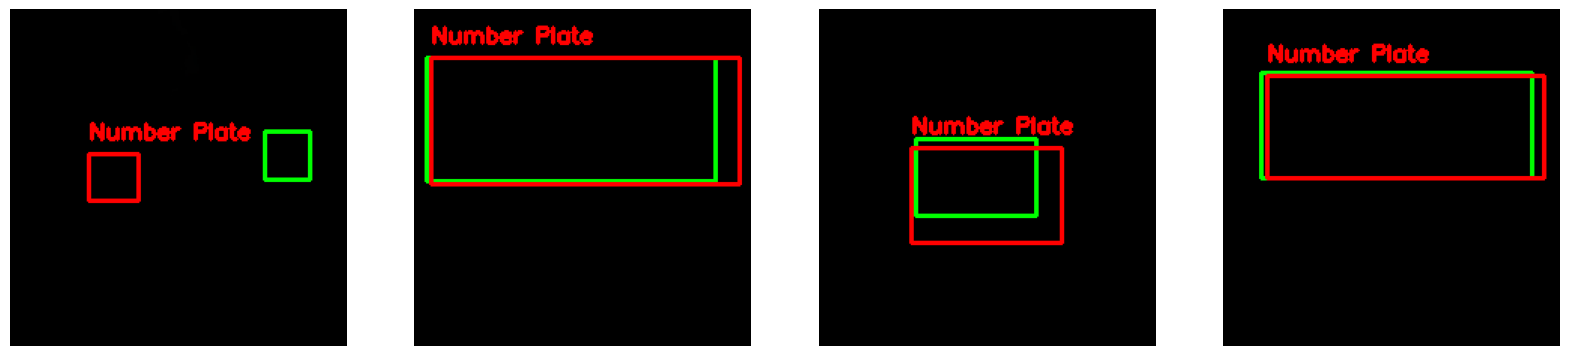

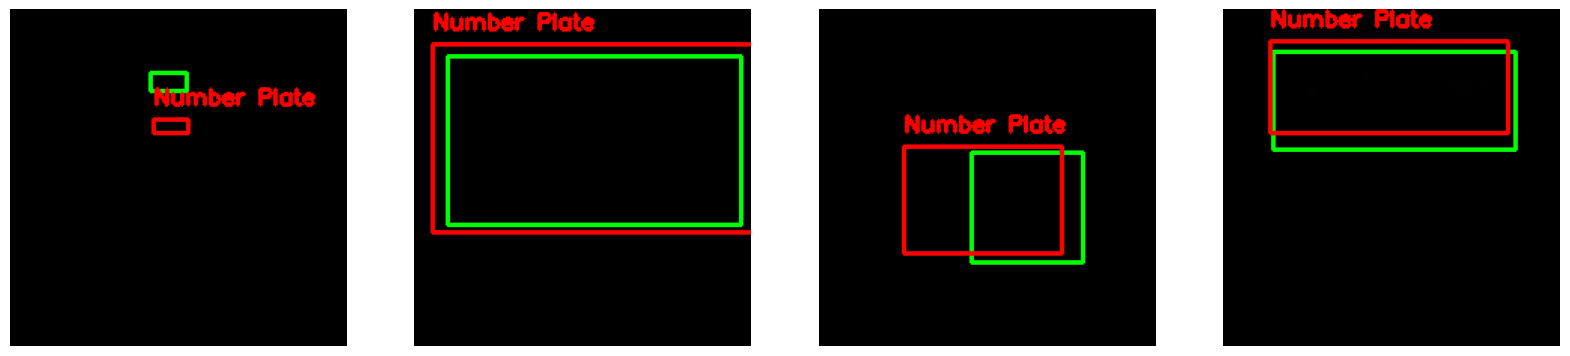

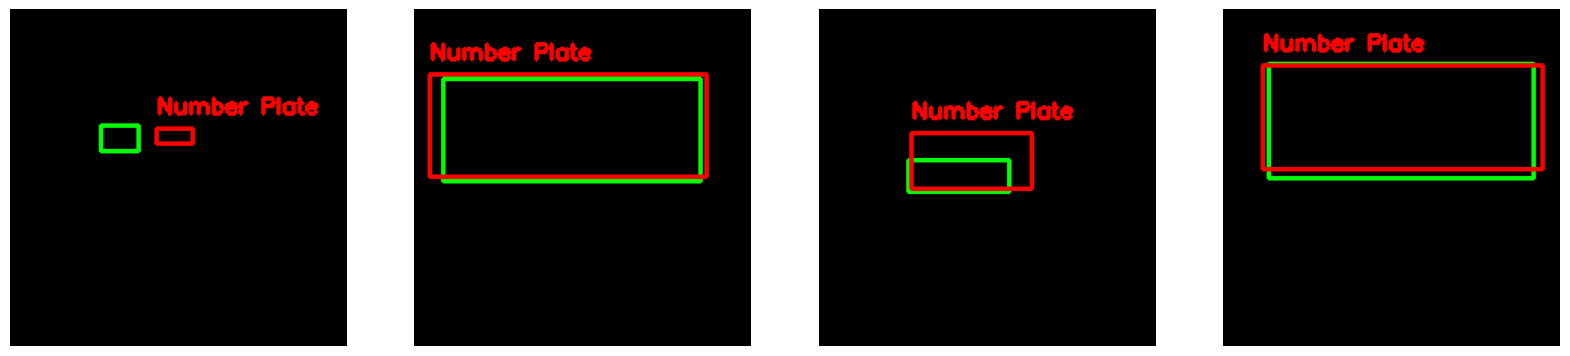

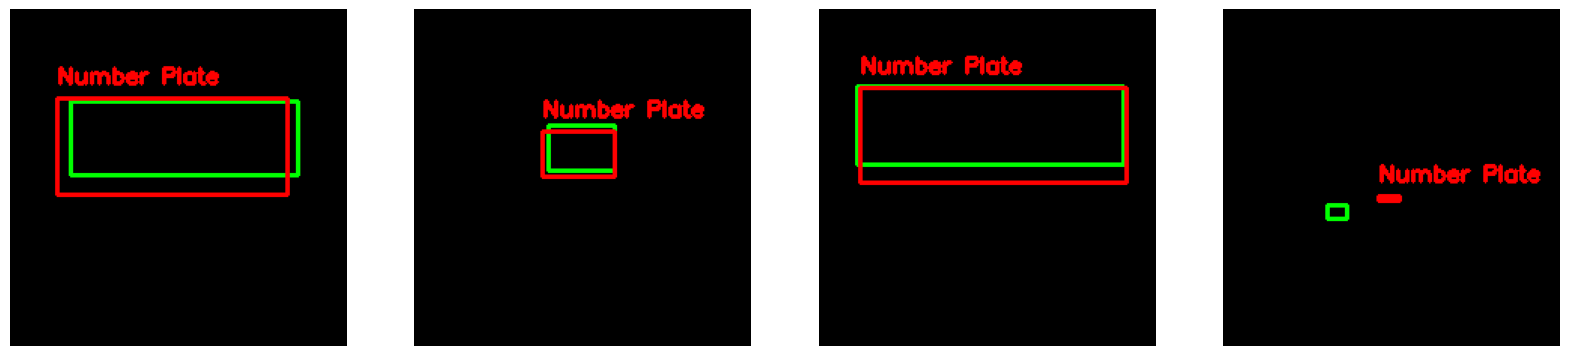

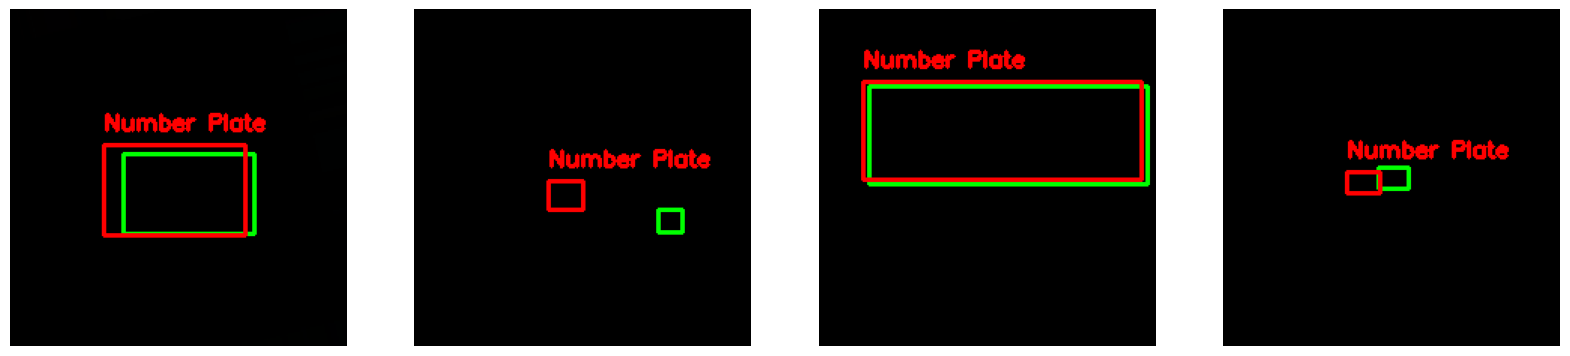

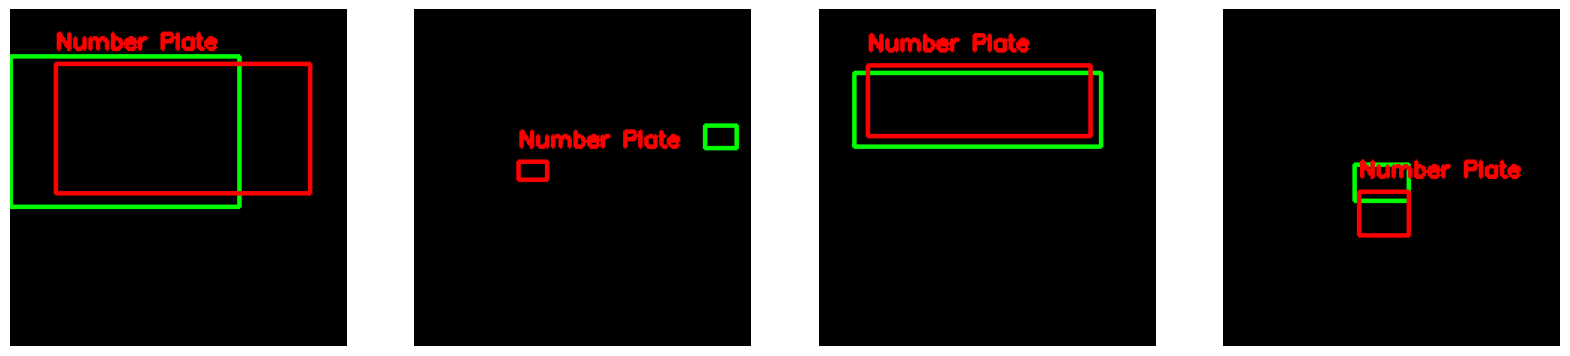

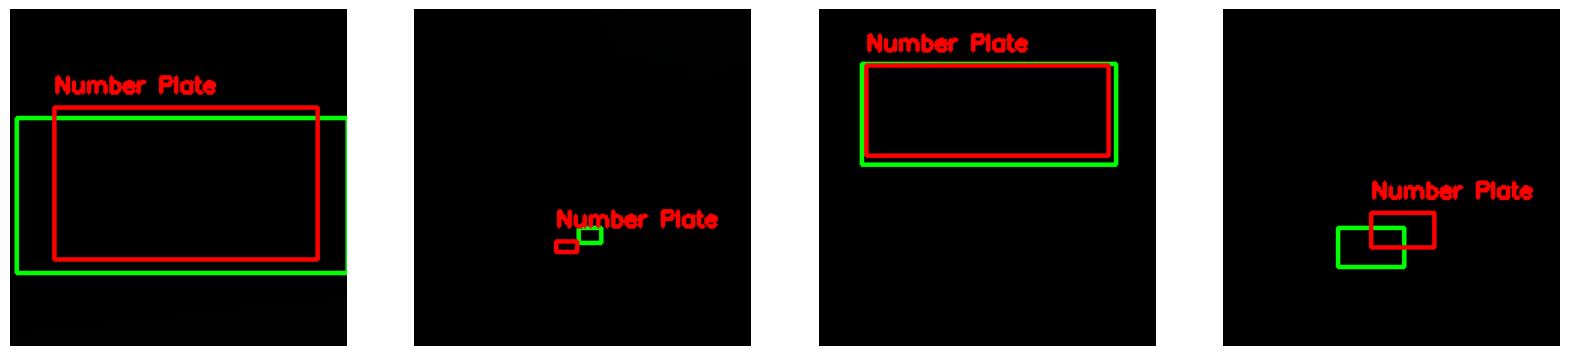

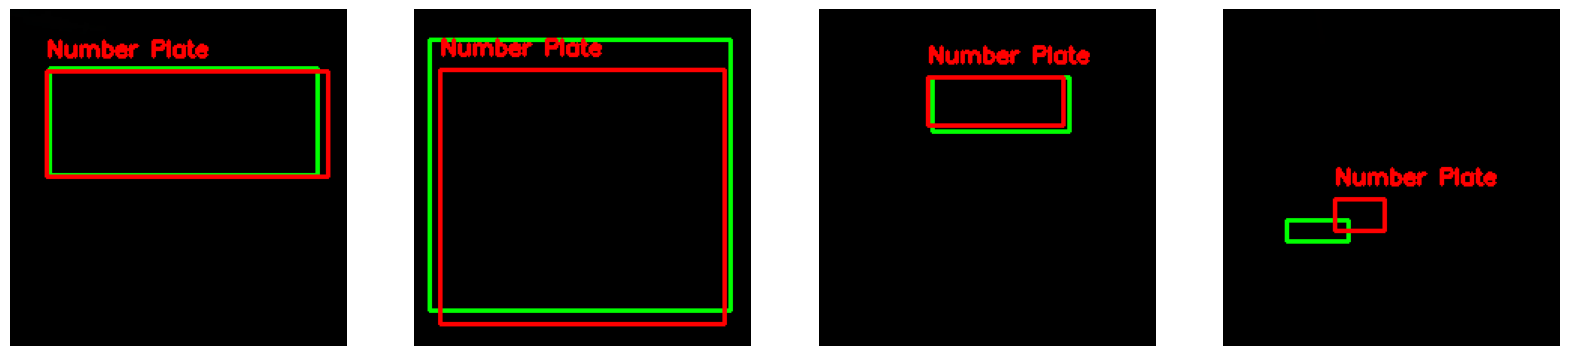

In [ ]:

import matplotlib.pyplot as plt

#Load model
InceptionResNetV2Model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Number-Plate-Recognition-Model/InceptionResNetV2Model1.h5')

# Directory Path
test_directory = r'/content/drive/MyDrive/Colab Notebooks/Number-Palte-Dataset/test'

# Data Generator for test set
test_generator = image_generator(test_directory, batch_size, input_shape)
images, annotations = next(test_generator)

model_predictions = InceptionResNetV2Model.predict(images)
for i in range(0, len(images), 4):
    fig, axs = plt.subplots(1, 4, figsize=(20, 10))
    for j in range(4):
        if i+j >= len(images):
            break
        image = images[i+j].astype('uint8')
        annotation = annotations[i+j]
        pred = model_predictions[i+j]
        X_min, Y_min, X_max, Y_max = annotation.astype('int')
        X_min1, Y_min1, X_max1, Y_max1 = pred.astype('int')
        cv2.rectangle(image, (X_min, Y_min), (X_max, Y_max), (0, 255, 0), 2)
        cv2.rectangle(image, (X_min1, Y_min1), (X_max1, Y_max1), (255,0,0), 2)
        cv2.putText(image, 'Number Plate', (X_min1, Y_min1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)
        axs[j].imshow(image)
        axs[j].axis('off')
    plt.show()


###**Performance Evaluation**

In [ ]:
# Directory Path
training_directory = '/content/drive/MyDrive/Colab Notebooks/Number-Palte-Dataset/train'
validation_directory = '/content/drive/MyDrive/Colab Notebooks/Number-Palte-Dataset/valid'
test_directory = '/content/drive/MyDrive/Colab Notebooks/Number-Palte-Dataset/test'

#Data Generator
train_generator = image_generator(training_directory, batch_size, input_shape)
training_steps = len(os.listdir(training_directory)) // batch_size

val_generator = image_generator(validation_directory, batch_size, input_shape)
val_steps = len(os.listdir(validation_directory)) // batch_size

test_generator = image_generator(test_directory, batch_size, input_shape)
test_steps = len(os.listdir(test_directory)) // batch_size

# Evaluate the performance on the validation set
validation_loss, validation_accuracy = InceptionResNetV2Model.evaluate(val_generator, steps=val_steps)

print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)

# Evaluate the performance on the training set
training_loss, training_accuracy = InceptionResNetV2Model.evaluate(train_generator, steps=training_steps)

print("Training Loss:", training_loss)
print("Training Accuracy:", training_accuracy)

# Evaluate the performance on the test set
test_loss, test_accuracy = InceptionResNetV2Model.evaluate(test_generator, steps=test_steps)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)


18/18 [==============================] - 15s 596ms/step - loss: 370.7016 - accuracy: 0.8576
Validation Loss: 370.7016296386719
Validation Accuracy: 0.8576388955116272
62/62 [==============================] - 40s 654ms/step - loss: 92.3865 - accuracy: 0.9557
Training Loss: 92.38648986816406
Training Accuracy: 0.9557477235794067
9/9 [==============================] - 7s 826ms/step - loss: 422.1875 - accuracy: 0.8791
Test loss: 422.1874694824219
Test accuracy: 0.8791208863258362


###**Visual Representation on Training and Validation**

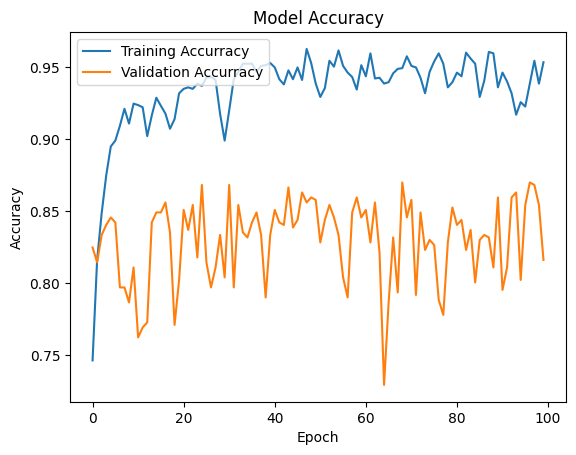

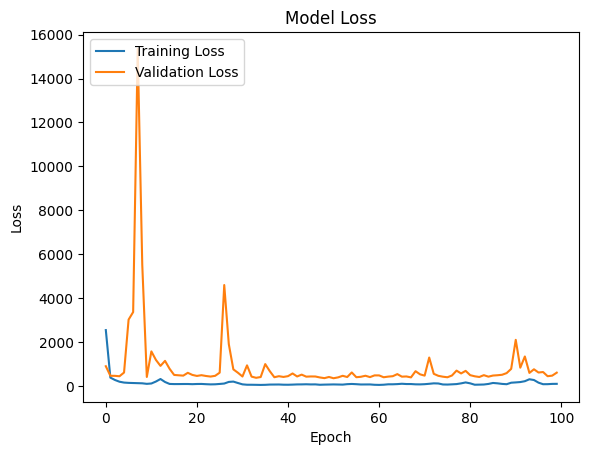

In [ ]:
import pickle

with open('/content/drive/MyDrive/Colab Notebooks/Number-Plate-Recognition-Model/inceptionResNetV2_model_history.pkl', 'rb') as f:
    history = pickle.load(f)

# Plot the accuracy over epochs
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accurracy', 'Validation Accurracy'], loc='upper left')
plt.show()

# Plot the loss over epochs
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
plt.show()


##**ResNet50**


In [ ]:

import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.optimizers import Adam
import xml.etree.ElementTree as ET
from tensorflow.keras.regularizers import l2
import pickle

# Define the input shape and batch size
input_shape = (224, 224, 3)
batch_size = 32

# Define the base model
base_model = ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last convolutional block of the base model
for layer in base_model.layers[-4:]:
    layer.trainable = True
# Add a custom head to the base model
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dense(4, activation='linear')(x)
model = Model(inputs=base_model.input, outputs=x)
# Compile the model

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

# Callback to the model
save_ResNet50_model = tf.keras.callbacks.ModelCheckpoint(
    "/content/drive/MyDrive/Colab Notebooks/Number-Plate-Recognition-Model/ResNet50Model.h5", 
    monitor='accuracy', 
    save_best_only=True, 
    verbose=1
)
# Directory Path
training_directory = '/content/drive/MyDrive/Colab Notebooks/Number-Palte-Dataset/train'
validation_directory = '/content/drive/MyDrive/Colab Notebooks/Number-Palte-Dataset/valid'

# Image Generator function
def image_generator(directory_path, batch_size, input_shape):
    while True:
        data = []
        train_annotation = []
        for filename in os.listdir(directory_path):
            if filename.split('.')[-1] in ['jpeg', 'jpg', 'png']:
                
                image_path = os.path.join(directory_path, filename)

                xml_path = os.path.join(directory_path, filename[:-4] +'.xml')

                tree = ET.parse(xml_path)
                root = tree.getroot()

                # Check boundbox
                boundingbox = root.find('object/bndbox')
                if boundingbox is not None:
                    X_min = int(boundingbox.find('xmin').text)
                    X_max = int(boundingbox.find('xmax').text)
                    Y_min = int(boundingbox.find('ymin').text)
                    Y_max = int(boundingbox.find('ymax').text)
                    train_annotation.append([X_min, Y_min, X_max, Y_max])

                    # Load image
                    image = cv2.imread(image_path)
                    image = cv2.resize(image, input_shape[:2])
                    data.append(image)

                    if len(data) == batch_size:
                        yield np.array(data), np.array(train_annotation) * 0.35
                        data = []
                        train_annotation = []

        if len(data) > 0:
            yield np.array(data), np.array(train_annotation) * 0.35
            
# Evaluate the performance on the validation set
train_generator = image_generator(training_directory, batch_size, input_shape)
training_steps = len(os.listdir(training_directory)) // batch_size

val_generator = image_generator(validation_directory, batch_size, input_shape)
val_steps = len(os.listdir(validation_directory)) // batch_size

# Train the model
ResNet50_model_history = model.fit(train_generator,
                                      steps_per_epoch=training_steps,
                                      epochs=100,
                                      verbose=1,
                                      validation_data=val_generator,
                                      validation_steps=val_steps,
                                      callbacks=[save_ResNet50_model])


# Save the history variable to a file in your Google Drive
with open('/content/drive/MyDrive/Colab Notebooks/Number-Plate-Recognition-Model/ResNet50_model_history.pkl', 'wb') as f:
    pickle.dump(ResNet50_model_history.history, f)


94765736/94765736 [==============================] - 2s 0us/step
Epoch 1/100
62/62 [==============================] - ETA: 0s - loss: 2630.4797 - accuracy: 0.7253
Epoch 1: accuracy improved from -inf to 0.72533, saving model to /content/drive/MyDrive/Colab Notebooks/Number-Plate-Recognition-Model/ResNet50Model.h5
62/62 [==============================] - 42s 568ms/step - loss: 2630.4797 - accuracy: 0.7253 - val_loss: 606.8500 - val_accuracy: 0.8229
Epoch 2/100
62/62 [==============================] - ETA: 0s - loss: 297.3908 - accuracy: 0.8717
Epoch 2: accuracy improved from 0.72533 to 0.87166, saving model to /content/drive/MyDrive/Colab Notebooks/Number-Plate-Recognition-Model/ResNet50Model.h5
62/62 [==============================] - 36s 582ms/step - loss: 297.3908 - accuracy: 0.8717 - val_loss: 446.3772 - val_accuracy: 0.8472
Epoch 3/100
62/62 [==============================] - ETA: 0s - loss: 126.0385 - accuracy: 0.9127
Epoch 3: accuracy improved from 0.87166 to 0.91273, saving mode

###**Test the model for detecting output**

In [ ]:

import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.optimizers import Adam
import xml.etree.ElementTree as ET
from tensorflow.keras.regularizers import l2
import pickle

# Define the input shape and batch size
input_shape = (224, 224, 3)
batch_size = 32

# Directory Path
training_directory = '/content/drive/MyDrive/Colab Notebooks/Number-Palte-Dataset/train'
validation_directory = '/content/drive/MyDrive/Colab Notebooks/Number-Palte-Dataset/valid'

# Image Generator function
def image_generator(directory_path, batch_size, input_shape):
    while True:
        data = []
        train_annotation = []
        for filename in os.listdir(directory_path):
            if filename.split('.')[-1] in ['jpeg', 'jpg', 'png']:
                
                image_path = os.path.join(directory_path, filename)

                xml_path = os.path.join(directory_path, filename[:-4] +'.xml')

                tree = ET.parse(xml_path)
                root = tree.getroot()

                # Check boundbox
                boundingbox = root.find('object/bndbox')
                if boundingbox is not None:
                    X_min = int(boundingbox.find('xmin').text)
                    X_max = int(boundingbox.find('xmax').text)
                    Y_min = int(boundingbox.find('ymin').text)
                    Y_max = int(boundingbox.find('ymax').text)
                    train_annotation.append([X_min, Y_min, X_max, Y_max])

                    # Load image
                    image = cv2.imread(image_path)
                    image = cv2.resize(image, input_shape[:2])
                    data.append(image)

                    if len(data) == batch_size:
                        yield np.array(data), np.array(train_annotation) * 0.35
                        data = []
                        train_annotation = []

        if len(data) > 0:
            yield np.array(data), np.array(train_annotation) * 0.35
            
# Evaluate the performance on the validation set
train_generator = image_generator(training_directory, batch_size, input_shape)
training_steps = len(os.listdir(training_directory)) // batch_size

val_generator = image_generator(validation_directory, batch_size, input_shape)
val_steps = len(os.listdir(validation_directory)) // batch_size


In [ ]:

import matplotlib.pyplot as plt

#Load model
ResNet50Model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Number-Plate-Recognition-Model/ResNet50Model.h5')

# Directory Path
test_directory = r'/content/drive/MyDrive/Colab Notebooks/Number-Palte-Dataset/test'

# Data Generator for test set
test_generator = image_generator(test_directory, batch_size, input_shape)
images, annotations = next(test_generator)

model_predictions = ResNet50Model.predict(images)
for i in range(0, len(images), 4):
    fig, axs = plt.subplots(1, 4, figsize=(20, 10))
    for j in range(4):
        if i+j >= len(images):
            break
        image = images[i+j].astype('uint8')
        annotation = annotations[i+j]
        pred = model_predictions[i+j]
        X_min, Y_min, X_max, Y_max = annotation.astype('int')
        X_min1, Y_min1, X_max1, Y_max1 = pred.astype('int')
        cv2.rectangle(image, (X_min, Y_min), (X_max, Y_max), (0, 255, 0), 2)
        cv2.rectangle(image, (X_min1, Y_min1), (X_max1, Y_max1), (255,0,0), 2)
        cv2.putText(image, 'Number Plate', (X_min1, Y_min1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)
        axs[j].imshow(image)
        axs[j].axis('off')
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

###**Performance Evaluation**

In [ ]:
# Directory Path
training_directory = '/content/drive/MyDrive/Colab Notebooks/Number-Palte-Dataset/train'
validation_directory = '/content/drive/MyDrive/Colab Notebooks/Number-Palte-Dataset/valid'
test_directory = '/content/drive/MyDrive/Colab Notebooks/Number-Palte-Dataset/test'

#Data Generator
train_generator = image_generator(training_directory, batch_size, input_shape)
training_steps = len(os.listdir(training_directory)) // batch_size

val_generator = image_generator(validation_directory, batch_size, input_shape)
val_steps = len(os.listdir(validation_directory)) // batch_size

test_generator = image_generator(test_directory, batch_size, input_shape)
test_steps = len(os.listdir(test_directory)) // batch_size

# Evaluate the performance on the validation set

validation_loss, validation_accuracy = ResNet50Model.evaluate(val_generator, steps=val_steps)

print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)

# Evaluate the performance on the training set
training_loss, training_accuracy = ResNet50Model.evaluate(train_generator, steps=training_steps)

print("Training Loss:", training_loss)
print("Training Accuracy:", training_accuracy)

# Evaluate the performance on the test set
test_loss, test_accuracy = ResNet50Model.evaluate(test_generator, steps=test_steps)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)


18/18 [==============================] - 6s 265ms/step - loss: 310.9759 - accuracy: 0.8576
Validation Loss: 310.97589111328125
Validation Accuracy: 0.8576388955116272
62/62 [==============================] - 18s 288ms/step - loss: 22.8699 - accuracy: 0.9898
Training Loss: 22.869890213012695
Training Accuracy: 0.989827036857605
9/9 [==============================] - 2s 246ms/step - loss: 291.7997 - accuracy: 0.9231
Test loss: 291.79974365234375
Test accuracy: 0.9230769276618958


###**Visual Representation on Training and Validataion**

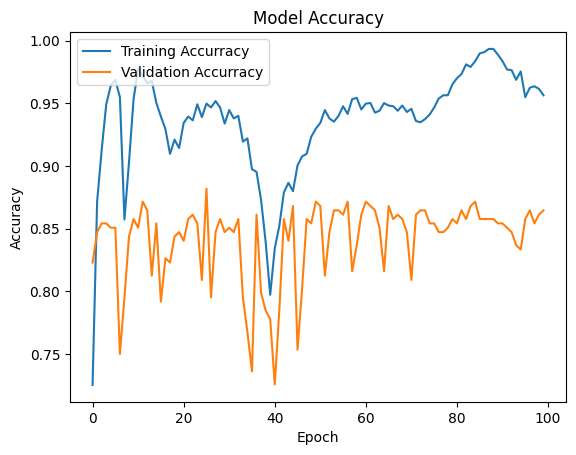

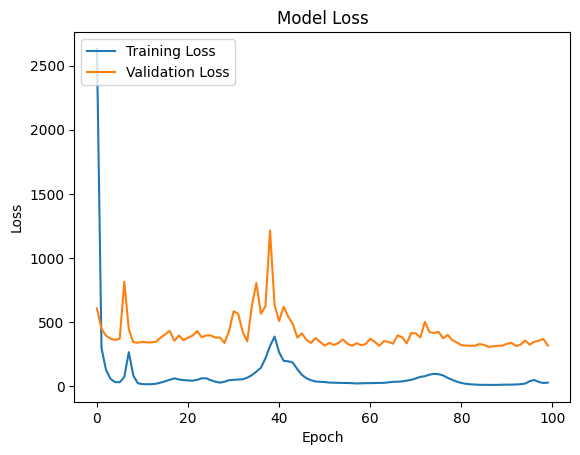

In [ ]:
import pickle

with open('/content/drive/MyDrive/Colab Notebooks/Number-Plate-Recognition-Model/ResNet50_model_history.pkl', 'rb') as f:
    history = pickle.load(f)

# Plot the accuracy over epochs
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accurracy', 'Validation Accurracy'], loc='upper left')
plt.show()

# Plot the loss over epochs
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
plt.show()


#**MaxPool Model**

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import xml.etree.ElementTree as ET
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle

# Define the input shape and batch size
input_shape = (224, 224, 3)
batch_size = 32

# Define the model architecture
model = Sequential()

# Add the first convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))

# Add the second convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Add the third convolutional layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Add a custom head to the base model

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(4, activation='linear'))
# Compile the model

# Compile the model with 'mse' loss and Adam optimizer with a learning rate of 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

# Define the callback function to save the model
save_MaxPool_model = ModelCheckpoint(
    "/content/drive/MyDrive/Colab Notebooks/Number-Plate-Recognition-Model/MaxPoolModel1.h5",
    monitor='accuracy',
    save_best_only=True,
    verbose=1
)

# Directory Path
training_directory = '/content/drive/MyDrive/Colab Notebooks/Number-Palte-Dataset/train'
validation_directory = '/content/drive/MyDrive/Colab Notebooks/Number-Palte-Dataset/valid'

# Image Generator function
def image_generator(directory_path, batch_size, input_shape):
    while True:
        data = []
        train_annotation = []
        for filename in os.listdir(directory_path):
            if filename.split('.')[-1] in ['jpeg', 'jpg', 'png']:
                
                image_path = os.path.join(directory_path, filename)

                xml_path = os.path.join(directory_path, filename[:-4] +'.xml')

                tree = ET.parse(xml_path)
                root = tree.getroot()

                # Check boundbox
                boundingbox = root.find('object/bndbox')
                if boundingbox is not None:
                    X_min = int(boundingbox.find('xmin').text)
                    X_max = int(boundingbox.find('xmax').text)
                    Y_min = int(boundingbox.find('ymin').text)
                    Y_max = int(boundingbox.find('ymax').text)
                    train_annotation.append([X_min, Y_min, X_max, Y_max])

                    # Load image
                    image = cv2.imread(image_path)
                    image = cv2.resize(image, input_shape[:2])
                    data.append(image)

                    if len(data) == batch_size:
                        yield np.array(data), np.array(train_annotation) * 0.35
                        data = []
                        train_annotation = []

        if len(data) > 0:
            yield np.array(data), np.array(train_annotation) * 0.35
           
# Evaluate the performance on the validation set
train_generator = image_generator(training_directory, batch_size, input_shape)
training_steps = len(os.listdir(training_directory)) // batch_size

val_generator = image_generator(validation_directory, batch_size, input_shape)
val_steps = len(os.listdir(validation_directory)) // batch_size

# Train the model
MaxPool_model_history = model.fit(train_generator,
                                      steps_per_epoch=training_steps,
                                      epochs=100,
                                      verbose=1,
                                      validation_data=val_generator,
                                      validation_steps=val_steps,
                                      callbacks=[save_MaxPool_model])            
# Save the history variable to a file in your Google Drive
with open('/content/drive/MyDrive/Colab Notebooks/Number-Plate-Recognition-Model/MaxPool_model_history.pkl', 'wb') as f:
    pickle.dump(MaxPool_model_history.history, f)

Epoch 1/100
62/62 [==============================] - ETA: 0s - loss: 3052.9602 - accuracy: 0.6775
Epoch 1: accuracy improved from -inf to 0.67752, saving model to /content/drive/MyDrive/Colab Notebooks/Number-Plate-Recognition-Model/MaxPoolModel1.h5
62/62 [==============================] - 43s 487ms/step - loss: 3052.9602 - accuracy: 0.6775 - val_loss: 1095.8883 - val_accuracy: 0.7674
Epoch 2/100
62/62 [==============================] - ETA: 0s - loss: 858.0762 - accuracy: 0.8054
Epoch 2: accuracy improved from 0.67752 to 0.80544, saving model to /content/drive/MyDrive/Colab Notebooks/Number-Plate-Recognition-Model/MaxPoolModel1.h5
62/62 [==============================] - 28s 462ms/step - loss: 858.0762 - accuracy: 0.8054 - val_loss: 857.5478 - val_accuracy: 0.7882
Epoch 3/100
62/62 [==============================] - ETA: 0s - loss: 518.8838 - accuracy: 0.8619
Epoch 3: accuracy improved from 0.80544 to 0.86191, saving model to /content/drive/MyDrive/Colab Notebooks/Number-Plate-Recogni

###**Test Model for detecting output**

In [ ]:
import matplotlib.pyplot as plt

#Load model
MaxPoolModel = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Number-Plate-Recognition-Model/MaxPoolModel1.h5')

# Directory Path
test_directory = r'/content/drive/MyDrive/Colab Notebooks/Number-Palte-Dataset/test'

# Data Generator for test set
test_generator = image_generator(test_directory, batch_size, input_shape)
images, annotations = next(test_generator)

model_predictions = MaxPoolModel.predict(images)
for i in range(0, len(images), 4):
    fig, axs = plt.subplots(1, 4, figsize=(20, 10))
    for j in range(4):
        if i+j >= len(images):
            break
        image = images[i+j].astype('uint8')
        annotation = annotations[i+j]
        pred = model_predictions[i+j]
        X_min, Y_min, X_max, Y_max = annotation.astype('int')
        X_min1, Y_min1, X_max1, Y_max1 = pred.astype('int')
        cv2.rectangle(image, (X_min, Y_min), (X_max, Y_max), (0, 255, 0), 2)
        cv2.rectangle(image, (X_min1, Y_min1), (X_max1, Y_max1), (255,0,0), 2)
        cv2.putText(image, 'Number Plate', (X_min1, Y_min1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)
        axs[j].imshow(image)
        axs[j].axis('off')
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

###**Performance Evaluation**

In [ ]:
# Directory Path
training_directory = '/content/drive/MyDrive/Colab Notebooks/Number-Palte-Dataset/train'
validation_directory = '/content/drive/MyDrive/Colab Notebooks/Number-Palte-Dataset/valid'
test_directory = '/content/drive/MyDrive/Colab Notebooks/Number-Palte-Dataset/test'

#Data Generator
train_generator = image_generator(training_directory, batch_size, input_shape)
training_steps = len(os.listdir(training_directory)) // batch_size

val_generator = image_generator(validation_directory, batch_size, input_shape)
val_steps = len(os.listdir(validation_directory)) // batch_size

test_generator = image_generator(test_directory, batch_size, input_shape)
test_steps = len(os.listdir(test_directory)) // batch_size

# Evaluate the performance on the validation set

validation_loss, validation_accuracy = MaxPoolModel.evaluate(val_generator, steps=val_steps)

print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)

# Evaluate the performance on the training set
training_loss, training_accuracy = MaxPoolModel.evaluate(train_generator, steps=training_steps)

print("Training Loss:", training_loss)
print("Training Accuracy:", training_accuracy)

# Evaluate the performance on the test set
test_loss, test_accuracy = MaxPoolModel.evaluate(test_generator, steps=test_steps)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)


18/18 [==============================] - 6s 313ms/step - loss: 750.1323 - accuracy: 0.8021
Validation Loss: 750.13232421875
Validation Accuracy: 0.8020833134651184
62/62 [==============================] - 23s 379ms/step - loss: 24.1397 - accuracy: 0.9700
Training Loss: 24.139711380004883
Training Accuracy: 0.9699898362159729
9/9 [==============================] - 4s 441ms/step - loss: 782.2273 - accuracy: 0.8095
Test loss: 782.227294921875
Test accuracy: 0.8095238208770752


###**Visual Representation on Trainging and Validation**

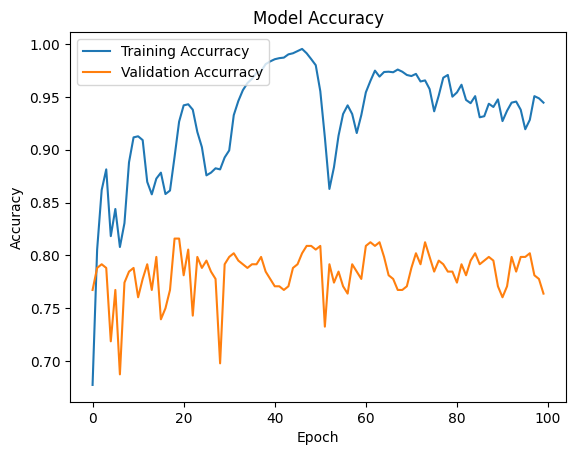

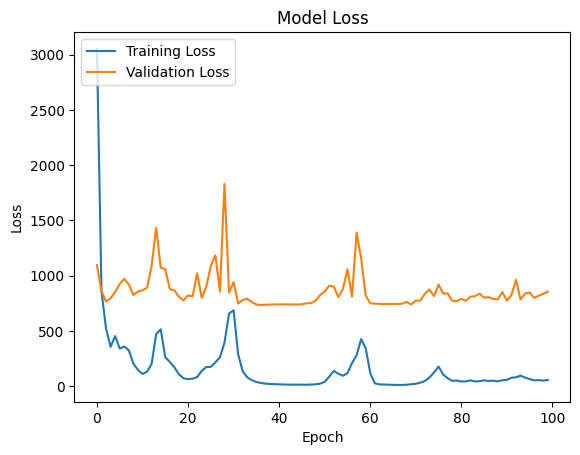

In [ ]:
import pickle

with open('/content/drive/MyDrive/Colab Notebooks/Number-Plate-Recognition-Model/MaxPool_model_history.pkl', 'rb') as f:
    history = pickle.load(f)

# Plot the accuracy over epochs
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accurracy', 'Validation Accurracy'], loc='upper left')
plt.show()

# Plot the loss over epochs
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
plt.show()


#**Average Pool Model**

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import xml.etree.ElementTree as ET
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle

# Define the input shape and batch size
input_shape = (224, 224, 3)
batch_size = 32

# Define the model architecture
model = Sequential()

# Add the first convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(AveragePooling2D((2, 2)))

# Add the second convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(AveragePooling2D((2, 2)))

# Add the third convolutional layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(AveragePooling2D((2, 2)))

# Add a flatten layer
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(4, activation='linear'))

# Compile the model with 'mse' loss and Adam optimizer with a learning rate of 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

# Define the callback function to save the model
save_AveragePool_model = ModelCheckpoint(
    "/content/drive/MyDrive/Colab Notebooks/Number-Plate-Recognition-Model/AveragePoolModel.h5",
    monitor='accuracy',
    save_best_only=True,
    verbose=1
)

# Directory Path
training_directory = '/content/drive/MyDrive/Colab Notebooks/Number-Palte-Dataset/train'
validation_directory = '/content/drive/MyDrive/Colab Notebooks/Number-Palte-Dataset/valid'

# Image Generator function
def image_generator(directory_path, batch_size, input_shape):
    while True:
        data = []
        train_annotation = []
        for filename in os.listdir(directory_path):
            if filename.split('.')[-1] in ['jpeg', 'jpg', 'png']:
                
                image_path = os.path.join(directory_path, filename)

                xml_path = os.path.join(directory_path, filename[:-4] +'.xml')

                tree = ET.parse(xml_path)
                root = tree.getroot()

                # Check boundbox
                boundingbox = root.find('object/bndbox')
                if boundingbox is not None:
                    X_min = int(boundingbox.find('xmin').text)
                    X_max = int(boundingbox.find('xmax').text)
                    Y_min = int(boundingbox.find('ymin').text)
                    Y_max = int(boundingbox.find('ymax').text)
                    train_annotation.append([X_min, Y_min, X_max, Y_max])

                    # Load image
                    image = cv2.imread(image_path)
                    image = cv2.resize(image, input_shape[:2])
                    data.append(image)

                    if len(data) == batch_size:
                        yield np.array(data), np.array(train_annotation) * 0.35
                        data = []
                        train_annotation = []

        if len(data) > 0:
            yield np.array(data), np.array(train_annotation) * 0.35
            
          
# Evaluate the performance on the validation set
train_generator = image_generator(training_directory, batch_size, input_shape)
training_steps = len(os.listdir(training_directory)) // batch_size

val_generator = image_generator(validation_directory, batch_size, input_shape)
val_steps = len(os.listdir(validation_directory)) // batch_size

# Train the model
AveragePool_model_history = model.fit(train_generator,
                                      steps_per_epoch=training_steps,
                                      epochs=100,
                                      verbose=1,
                                      validation_data=val_generator,
                                      validation_steps=val_steps,
                                      callbacks=[save_AveragePool_model])       
     
# Save the history variable to a file in your Google Drive
with open('/content/drive/MyDrive/Colab Notebooks/Number-Plate-Recognition-Model/AveragePool_model_history.pkl', 'wb') as f:
    pickle.dump(AveragePool_model_history.history, f)

Epoch 1/100
62/62 [==============================] - ETA: 0s - loss: 3068.2808 - accuracy: 0.6511
Epoch 1: accuracy improved from -inf to 0.65107, saving model to /content/drive/MyDrive/Colab Notebooks/Number-Plate-Recognition-Model/AveragePoolModel.h5
62/62 [==============================] - 36s 508ms/step - loss: 3068.2808 - accuracy: 0.6511 - val_loss: 1115.5793 - val_accuracy: 0.7674
Epoch 2/100
62/62 [==============================] - ETA: 0s - loss: 902.7848 - accuracy: 0.7947
Epoch 2: accuracy improved from 0.65107 to 0.79466, saving model to /content/drive/MyDrive/Colab Notebooks/Number-Plate-Recognition-Model/AveragePoolModel.h5
62/62 [==============================] - 34s 563ms/step - loss: 902.7848 - accuracy: 0.7947 - val_loss: 887.2875 - val_accuracy: 0.7674
Epoch 3/100
62/62 [==============================] - ETA: 0s - loss: 604.3066 - accuracy: 0.8393
Epoch 3: accuracy improved from 0.79466 to 0.83932, saving model to /content/drive/MyDrive/Colab Notebooks/Number-Plate-R

###**Test the model for detecting output**

In [ ]:
import matplotlib.pyplot as plt

#Load model
AveragePoolModel = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Number-Plate-Recognition-Model/AveragePoolModel.h5')

# Directory Path
test_directory = r'/content/drive/MyDrive/Colab Notebooks/Number-Palte-Dataset/test'

# Data Generator for test set
test_generator = image_generator(test_directory, batch_size, input_shape)
images, annotations = next(test_generator)

model_predictions = AveragePoolModel.predict(images)
for i in range(0, len(images), 4):
    fig, axs = plt.subplots(1, 4, figsize=(20, 10))
    for j in range(4):
        if i+j >= len(images):
            break
        image = images[i+j].astype('uint8')
        annotation = annotations[i+j]
        pred = model_predictions[i+j]
        X_min, Y_min, X_max, Y_max = annotation.astype('int')
        X_min1, Y_min1, X_max1, Y_max1 = pred.astype('int')
        cv2.rectangle(image, (X_min, Y_min), (X_max, Y_max), (0, 255, 0), 2)
        cv2.rectangle(image, (X_min1, Y_min1), (X_max1, Y_max1), (255,0,0), 2)
        cv2.putText(image, 'Number Plate', (X_min1, Y_min1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)
        axs[j].imshow(image)
        axs[j].axis('off')
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

###**Performance Evaluation**

In [ ]:
# Directory Path
training_directory = '/content/drive/MyDrive/Colab Notebooks/Number-Palte-Dataset/train'
validation_directory = '/content/drive/MyDrive/Colab Notebooks/Number-Palte-Dataset/valid'
test_directory = '/content/drive/MyDrive/Colab Notebooks/Number-Palte-Dataset/test'

#Data Generator
train_generator = image_generator(training_directory, batch_size, input_shape)
training_steps = len(os.listdir(training_directory)) // batch_size

val_generator = image_generator(validation_directory, batch_size, input_shape)
val_steps = len(os.listdir(validation_directory)) // batch_size

test_generator = image_generator(test_directory, batch_size, input_shape)
test_steps = len(os.listdir(test_directory)) // batch_size

# Evaluate the performance on the validation set

validation_loss, validation_accuracy = AveragePoolModel.evaluate(val_generator, steps=val_steps)

print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)

# Evaluate the performance on the training set
training_loss, training_accuracy = AveragePoolModel.evaluate(train_generator, steps=training_steps)

print("Training Loss:", training_loss)
print("Training Accuracy:", training_accuracy)

# Evaluate the performance on the test set
test_loss, test_accuracy = AveragePoolModel.evaluate(test_generator, steps=test_steps)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)


18/18 [==============================] - 5s 277ms/step - loss: 831.7375 - accuracy: 0.7812
Validation Loss: 831.737548828125
Validation Accuracy: 0.78125
62/62 [==============================] - 19s 306ms/step - loss: 30.0478 - accuracy: 0.9507
Training Loss: 30.047800064086914
Training Accuracy: 0.9506612420082092
9/9 [==============================] - 2s 236ms/step - loss: 869.4995 - accuracy: 0.7766
Test loss: 869.49951171875
Test accuracy: 0.7765567898750305


###**Visual Representation on Training and Validation**

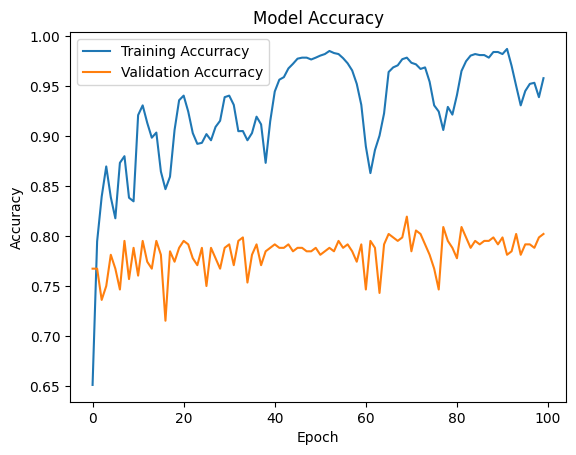

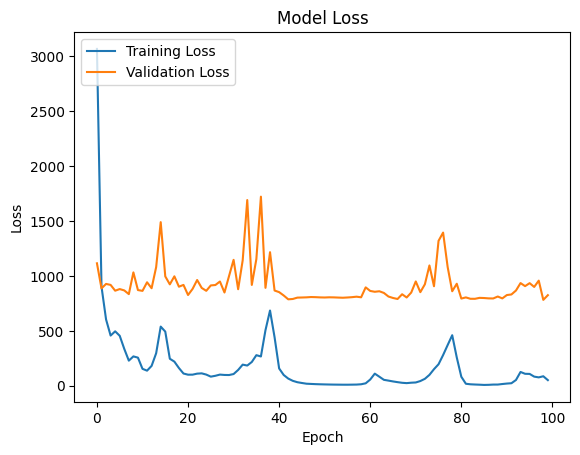

In [ ]:
import pickle

with open('/content/drive/MyDrive/Colab Notebooks/Number-Plate-Recognition-Model/AveragePool_model_history.pkl', 'rb') as f:
    history = pickle.load(f)

# Plot the accuracy over epochs
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accurracy', 'Validation Accurracy'], loc='upper left')
plt.show()

# Plot the loss over epochs
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
plt.show()
